# 6.5: Unsupervised Machine Learning: Clustering

## Table of Contents

[01. Importing libraries](#01.-Importing-libraries)

[02. Imporing Data](#02.-Imporing-Data)

[03. Data Preparation](#03.-Data-Preparation)

[04. The elbow technique](#04.-The-elbow-technique)

[05. k-means clustering](#05.-k-means-clustering)

[06 Discussion of Results](#06-Discussion-of-Results)

## 01. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.
from sklearn.preprocessing import StandardScaler

## 02. Imporing Data

In [2]:
# Import Divvy_trip dataset
df = pd.read_pickle( r'E:\Careerfoundry course\My Project\Generated Data\Divvy_cleaned.pkl')

In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
df.head()

,trip_id,start_time,end_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,...,to_latitude,to_longitude,to_location,year,month_start,month_end,day,hour_start,hour_end,age
0,8546790,2015-12-31 17:35:00,2015-12-31 17:44:00,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,Subscriber,...,41.943739,-87.664020,POINT (-87.66402 41.943739),2015,12,12,Thursday,17,17,24
1,8546793,2015-12-31 17:37:00,2015-12-31 17:41:00,1932,256,301,Clark St & Schiller St,138,Clybourn Ave & Division St,Subscriber,...,41.904613,-87.640552,POINT (-87.640552 41.904613),2015,12,12,Thursday,17,17,23
2,8546795,2015-12-31 17:37:00,2015-12-31 17:40:00,1693,134,465,Marine Dr & Ainslie St,251,Clarendon Ave & Leland Ave,Subscriber,...,41.967968,-87.650001,POINT (-87.650001 41.967968),2015,12,12,Thursday,17,17,28
3,8546797,2015-12-31 17:38:00,2015-12-31 17:55:00,3370,995,333,Ashland Ave & Blackhawk St,198,Green St (Halsted St) & Madison St,Subscriber,...,41.881892,-87.648789,POINT (-87.648789 41.881892),2015,12,12,Thursday,17,17,40
4,8546798,2015-12-31 17:38:00,2015-12-31 17:41:00,2563,177,48,Larrabee St & Kingsbury St,111,Sedgwick St & Huron St,Subscriber,...,41.894666,-87.638437,POINT (-87.638437 41.894666),2015,12,12,Thursday,17,17,25


In [5]:
df.dtypes

trip_id                      object
start_time           datetime64[ns]
end_time             datetime64[ns]
bike_id                      object
trip_duration                 int64
from_station_id              object
from_station_name            object
to_station_id                object
to_station_name              object
user_type                    object
gender                       object
birth_year                    int32
from_latitude               float64
from_longitude              float64
from_location                object
to_latitude                 float64
to_longitude                float64
to_location                  object
year                          int32
month_start                   int32
month_end                     int32
day                          object
hour_start                    int32
hour_end                      int32
age                           int32
dtype: object

## 03. Data Preparation

In [6]:
# Add a new column "distance_km" into the dataframe by calculating the distance between the from_latitude,
# from_longitude, to_latitude, and to_longitude columns using the Haversine formula.

In [7]:
# Haversine formula function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    
    # Convert degrees to radians
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = np.radians([lat1, lon1, lat2, lon2])
    
    # Compute the differences between latitudes and longitudes
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Apply Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c  # Distance in kilometers
    return distance

# Applying the function to create a new 'distance_km' column
df['distance_km'] = df.apply(lambda row: haversine(row['from_latitude'], row['from_longitude'], 
                                                   row['to_latitude'], row['to_longitude']), axis=1)

# Preview the dataset with the new distance column
print(df[['from_latitude', 'from_longitude', 'to_latitude', 'to_longitude', 'distance_km']].head())

   from_latitude  from_longitude  to_latitude  to_longitude  distance_km
0      41.940180      -87.653040    41.943739    -87.664020     0.990628
1      41.907993      -87.631501    41.904613    -87.640552     0.838025
2      41.971600      -87.650154    41.967968    -87.650001     0.404058
3      41.907066      -87.667252    41.881892    -87.648789     3.189205
4      41.897764      -87.642884    41.894666    -87.638437     0.504128


In [8]:
# Create copy of the data:
df1 = df

In [10]:
df1.head(1)

,trip_id,start_time,end_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,...,to_longitude,to_location,year,month_start,month_end,day,hour_start,hour_end,age,distance_km
0,8546790,2015-12-31 17:35:00,2015-12-31 17:44:00,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,Subscriber,...,-87.66402,POINT (-87.66402 41.943739),2015,12,12,Thursday,17,17,24,0.990628


In [11]:
df1_Filtered = df[(df['start_time'].dt.year >= 2015) & (df['start_time'].dt.year <= 2019)]

In [12]:
df1_Filtered.shape

(18021244, 26)

In [13]:
df1_Filtered .to_csv(r'E:\Careerfoundry course\My Project\Generated Data\Divvy_Filtered2.txt', sep='\t', index=False)

In [10]:
df1['day'].value_counts()

day
Tuesday      3163131
Friday       3124783
Monday       3113228
Thursday     3098872
Wednesday    3086239
Saturday     2948405
Sunday       2700124
Name: count, dtype: int64

In [11]:
# Convert user type to 0,1:
df1['user_type'] = df1['user_type'].replace({'Customer': '0', 'Subscriber': '1'})

In [12]:
df1['day'] = df1['day'].replace({'Monday': '1', 'Tuesday': '2', 'Wednesday': '3', 'Thursday': '4', 'Friday': '5', 'Saturday': '6', 'Sunday': '7'})

In [13]:
df1.head()

,trip_id,start_time,end_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,...,to_longitude,to_location,year,month_start,month_end,day,hour_start,hour_end,age,distance_km
0,8546790,2015-12-31 17:35:00,2015-12-31 17:44:00,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,1,...,-87.664020,POINT (-87.66402 41.943739),2015,12,12,4,17,17,24,0.990628
1,8546793,2015-12-31 17:37:00,2015-12-31 17:41:00,1932,256,301,Clark St & Schiller St,138,Clybourn Ave & Division St,1,...,-87.640552,POINT (-87.640552 41.904613),2015,12,12,4,17,17,23,0.838025
2,8546795,2015-12-31 17:37:00,2015-12-31 17:40:00,1693,134,465,Marine Dr & Ainslie St,251,Clarendon Ave & Leland Ave,1,...,-87.650001,POINT (-87.650001 41.967968),2015,12,12,4,17,17,28,0.404058
3,8546797,2015-12-31 17:38:00,2015-12-31 17:55:00,3370,995,333,Ashland Ave & Blackhawk St,198,Green St (Halsted St) & Madison St,1,...,-87.648789,POINT (-87.648789 41.881892),2015,12,12,4,17,17,40,3.189205
4,8546798,2015-12-31 17:38:00,2015-12-31 17:41:00,2563,177,48,Larrabee St & Kingsbury St,111,Sedgwick St & Huron St,1,...,-87.638437,POINT (-87.638437 41.894666),2015,12,12,4,17,17,25,0.504128


In [14]:
# Select the features that I want to use for clustering
X = df1[['distance_km', 'trip_duration', 'age', 'hour_start', 'day', 'month_start', 'user_type']]

In [15]:
X.head(1)

,distance_km,trip_duration,age,hour_start,day,month_start,user_type
0,0.990628,521,24,17,4,12,1


In [16]:
#  normalize or standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_scaled

array([[-0.63570052, -0.04027778, -1.10704292, ...,  0.03886604,
         1.88541936,  0.57899607],
       [-0.72879028, -0.05786173, -1.21219058, ...,  0.03886604,
         1.88541936,  0.57899607],
       [-0.99351489, -0.06595698, -0.6864523 , ...,  0.03886604,
         1.88541936,  0.57899607],
       ...,
       [ 1.59729785,  0.00782924,  1.10105785, ..., -1.47990808,
         0.71158833,  0.57899607],
       [ 0.10371636, -0.02906387, -0.79159995, ..., -1.47990808,
         0.71158833,  0.57899607],
       [-0.75333822, -0.04877116, -0.89674761, ..., -1.47990808,
         0.71158833,  0.57899607]])

## 04. The elbow technique

In [18]:
num_cl = range(1, 10) # Defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.

In [19]:
X_scaled = pd.DataFrame(X_scaled)

In [20]:
X_scaled.head(2)

,0,1,2,3,4,5,6
0,-0.635701,-0.040278,-1.107043,0.679216,0.038866,1.885419,0.578996
1,-0.728790,-0.057862,-1.212191,0.679216,0.038866,1.885419,0.578996


In [21]:
X_scaled.columns = ['distance_km', 'trip_duration', 'age', 'hour_start', 'day', 'month_start', 'user_type']

In [22]:
X_scaled.head(2)

,distance_km,trip_duration,age,hour_start,day,month_start,user_type
0,-0.635701,-0.040278,-1.107043,0.679216,0.038866,1.885419,0.578996
1,-0.728790,-0.057862,-1.212191,0.679216,0.038866,1.885419,0.578996


In [23]:
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.

score

[-148643473.99999893,
 -125546755.07310462,
 -110603951.31465432,
 -100359472.21934412,
 -92948421.57470398,
 -86062322.50148362,
 -71168846.17895743,
 -69752519.75825688,
 -65252415.821903214]

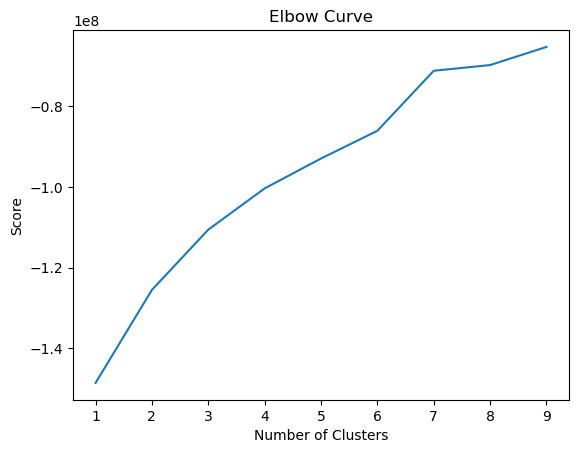

In [24]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl, score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#### The optimal number of clusters in the elbow curve you provided appears to be 3. This is where the curve starts to flatten out, indicating that adding more clusters beyond this point does not significantly improve the score. However, when I chose 3 clusters, I only got one color (cluster) in the visualization. Therefore, I decided to select 4 clusters for K-means.

#### I chose The Elbow Method because it is easy to use and understand. Just plot a graph of the within-cluster sum of squares (WCSS) against the number of clusters and look for a point where the curve bends like an elbow. This point suggests the best number of clusters because adding more clusters beyond this point doesn’t improve the model much.

## 05. k-means clustering

In [25]:
X_scaled.head(2)

,distance_km,trip_duration,age,hour_start,day,month_start,user_type
0,-0.635701,-0.040278,-1.107043,0.679216,0.038866,1.885419,0.578996
1,-0.728790,-0.057862,-1.212191,0.679216,0.038866,1.885419,0.578996


In [26]:
# Create the k-means object.
kmeans = KMeans(n_clusters = 4) 

In [27]:
# Fit the k-means object to the data.
kmeans.fit(X_scaled)

KMeans(n_clusters=4)

In [28]:
X_scaled['clusters'] = kmeans.fit_predict(X_scaled)

In [29]:
X_scaled.head()

,distance_km,trip_duration,age,hour_start,day,month_start,user_type,clusters
0,-0.635701,-0.040278,-1.107043,0.679216,0.038866,1.885419,0.578996,0
1,-0.728790,-0.057862,-1.212191,0.679216,0.038866,1.885419,0.578996,0
2,-0.993515,-0.065957,-0.686452,0.679216,0.038866,1.885419,0.578996,0
3,0.705455,-0.008826,0.575320,0.679216,0.038866,1.885419,0.578996,0
4,-0.932471,-0.063104,-1.001895,0.679216,0.038866,1.885419,0.578996,0


In [30]:
X_scaled['clusters'].value_counts()

clusters
0    11588258
1     5314192
3     4332127
2         205
Name: count, dtype: int64

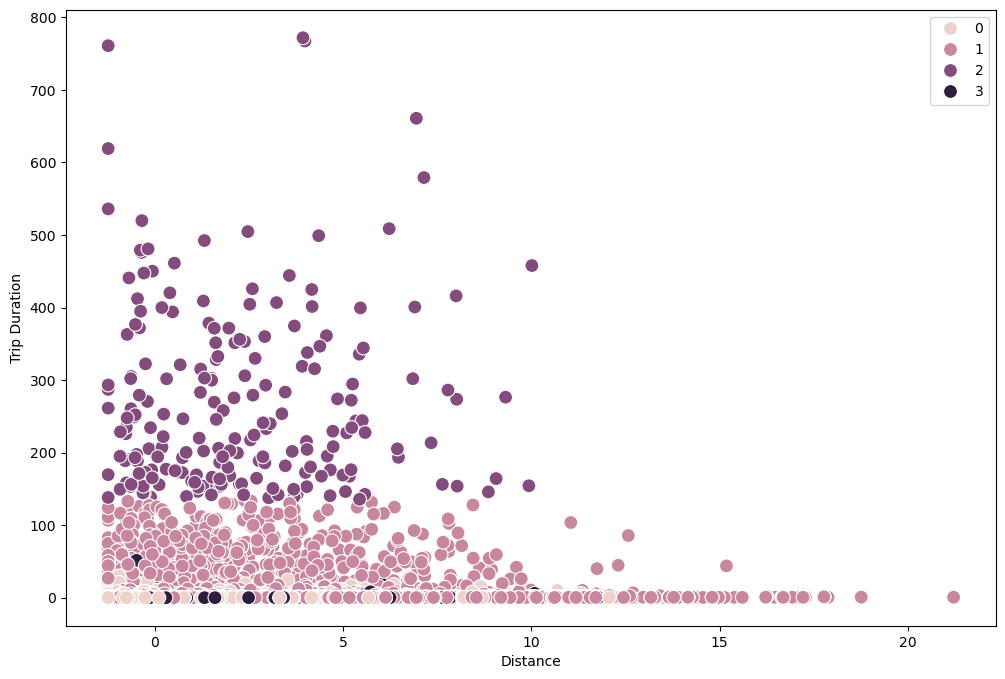

In [31]:
# Plot the clusters for the "Trip Duration" and "Distance" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=X_scaled['distance_km'], y=X_scaled['trip_duration'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Distance') # Label x-axis.
plt.ylabel('Trip Duration') # Label y-axis.
plt.show()

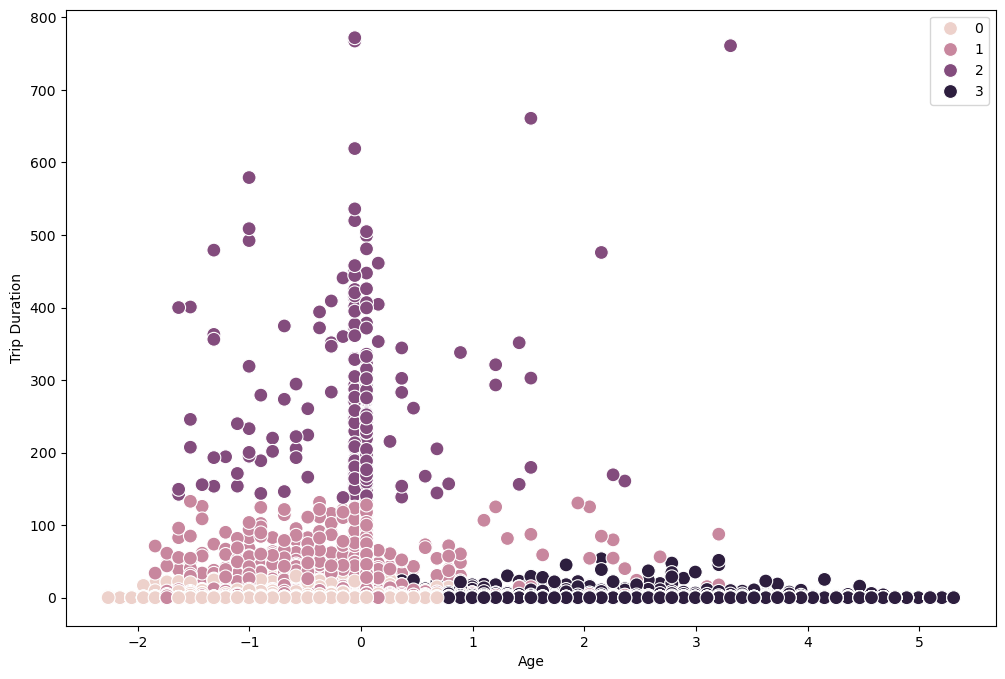

In [32]:
# Plot the clusters for the "Trip Duration" and "Age" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=X_scaled['age'], y=X_scaled['trip_duration'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('Age') 
plt.ylabel('Trip Duration') 
plt.show()

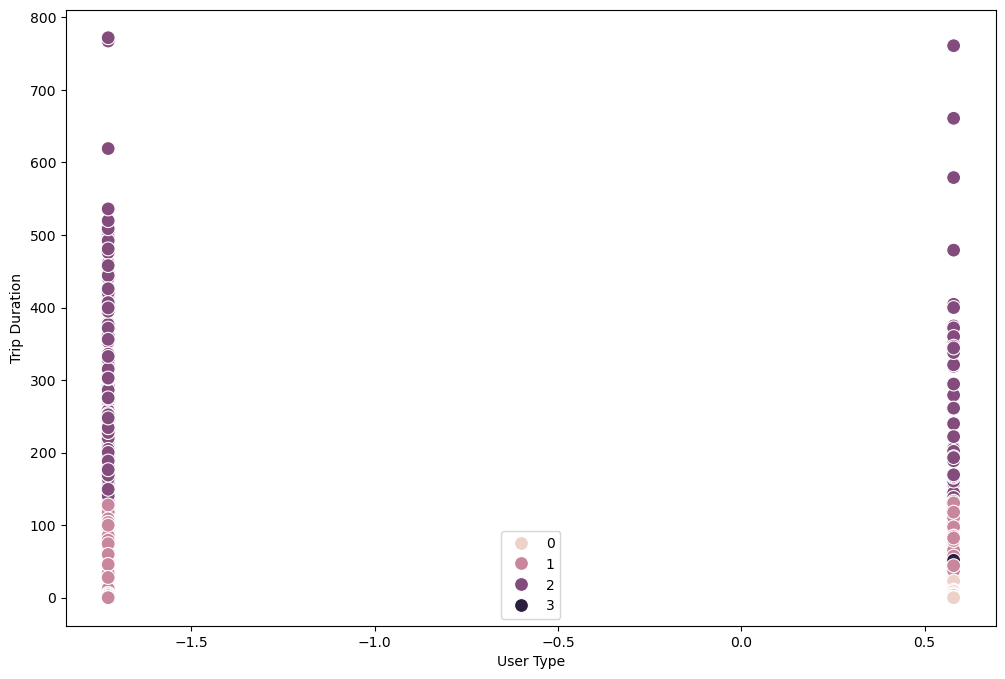

In [33]:
# Plot the clusters for the "Trip Duration" and "User Type" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=X_scaled['user_type'], y=X_scaled['trip_duration'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('User Type') 
plt.ylabel('Trip Duration') 
plt.show()

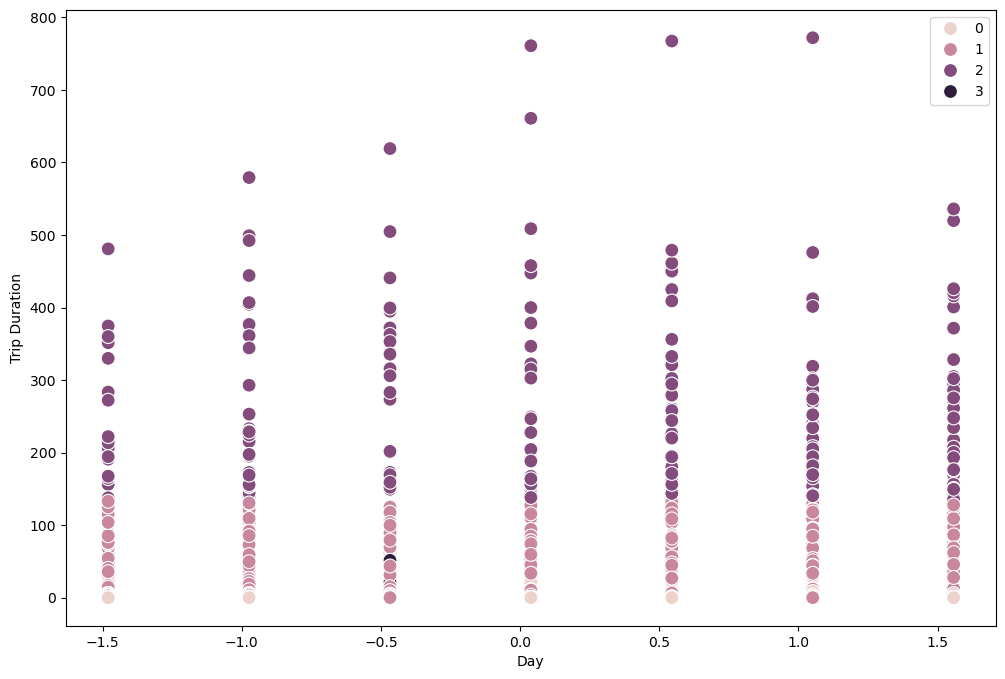

In [34]:
# Plot the clusters for the "Day" and "Trip Duration" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=X_scaled['day'].sort_values(), y=X_scaled['trip_duration'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('Day') 
plt.ylabel('Trip Duration') 
plt.show()

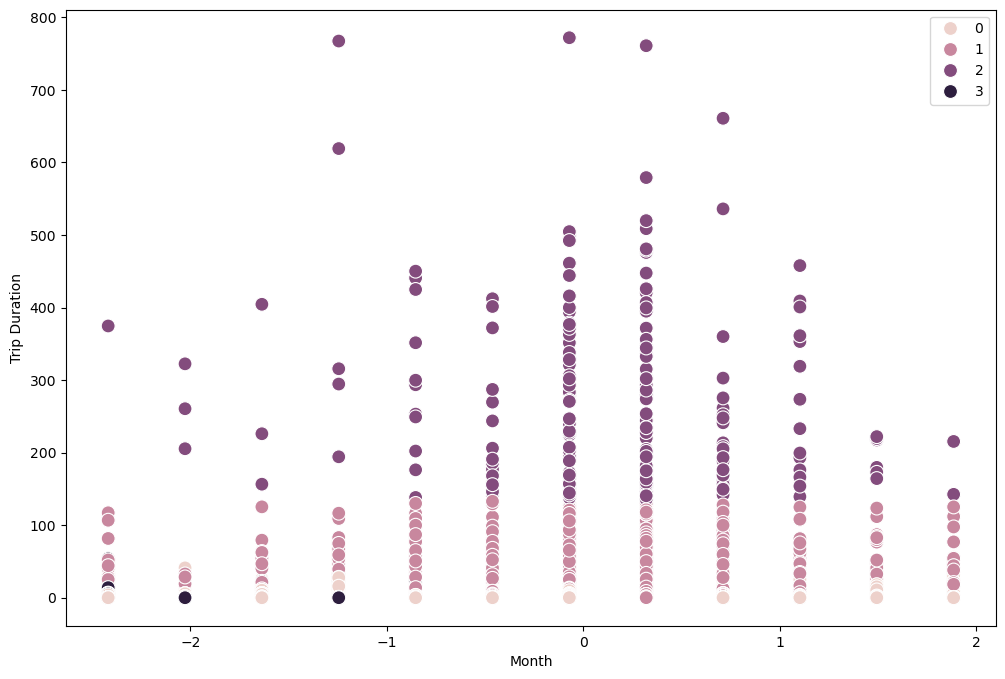

In [35]:
# Plot the clusters for the "Month" and "Trip Duration" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=X_scaled['month_start'], y=X_scaled['trip_duration'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('Month') 
plt.ylabel('Trip Duration') 
plt.show()

In [36]:
X_scaled.head(2)

,distance_km,trip_duration,age,hour_start,day,month_start,user_type,clusters
0,-0.635701,-0.040278,-1.107043,0.679216,0.038866,1.885419,0.578996,0
1,-0.728790,-0.057862,-1.212191,0.679216,0.038866,1.885419,0.578996,0


In [37]:
X_scaled.loc[X_scaled.loc[:, 'clusters'] == 3, 'cluster'] = 'dark purple'
X_scaled.loc[X_scaled.loc[:, 'clusters'] == 2, 'cluster'] = 'purple'
X_scaled.loc[X_scaled.loc[:, 'clusters'] == 1, 'cluster'] = 'dark pink'
X_scaled.loc[X_scaled.loc[:, 'clusters'] == 0, 'cluster'] = 'pink'

In [38]:
X_scaled.dtypes

distance_km      float64
trip_duration    float64
age              float64
hour_start       float64
day              float64
month_start      float64
user_type        float64
clusters           int32
cluster           object
dtype: object

In [39]:
X_scaled.loc[:, 'day'] = X_scaled['day'].astype(int)
X_scaled.loc[:, 'user_type'] = X_scaled['user_type'].astype(int)

In [40]:
X_scaled.head(1)

,distance_km,trip_duration,age,hour_start,day,month_start,user_type,clusters,cluster
0,-0.635701,-0.040278,-1.107043,0.679216,0.0,1.885419,0.0,0,pink


In [41]:
X_scaled.groupby('cluster').agg({
    'trip_duration': ['mean', 'median'],
    'distance_km': ['mean', 'median'],
    'age': ['mean', 'median'],
    'user_type': ['mean', 'median'],
    'month_start': ['mean', 'median'],
    'day': ['mean', 'median'],
})

trip_duration             distance_km                 age  \
                     mean      median        mean    median      mean   
cluster                                                                 
dark pink        0.065565    0.016522    0.127619 -0.169972 -0.283585   
dark purple     -0.026496   -0.037690   -0.149896 -0.394243  1.652399   
pink            -0.024932   -0.036097   -0.002527 -0.288917 -0.487680   
purple         269.631450  233.007680    2.257655  1.732230 -0.083777   

                      user_type        month_start                 day         
               median      mean median        mean    median      mean median  
cluster                                                                        
dark pink   -0.265862 -0.999975   -1.0    0.010946 -0.070966  0.359180    0.0  
dark purple  1.521648 -0.003964    0.0   -0.083330 -0.070966 -0.042886    0.0  
pink        -0.581305  0.000000    0.0    0.026130 -0.070966  0.070095    0.0  
purple      -0.055566 -0.809756   -1.0    0.117992  0.320311  0.273171    0.0

## 06 Discussion of Results

#### Based on the clustering output, we have four distinct clusters: dark pink, dark purple, pink, and purple.
1. Trip Duration: In terms of trip duration, purple stands out with exceptionally long trips (mean = 269.63, median = 233.01), suggesting it might contain a specific group of users or outliers with a tendency for very long journeys. In contrast, dark purple, pink, and dark pink clusters show shorter trip durations, with both mean and median values negative for the first two. dark pink has slightly longer trips compared to the others (mean = 0.065565), indicating that while the majority of trips are shorter, there is a mix of moderately long trips within the group.
2. Distance (km): When looking at distance, purple users again take the longest trips (mean = 2.257655, median = 1.732230), aligning with their long trip durations. dark pink shows a mixture of trip distances, as the mean is positive (0.127619) while the median is negative (-0.169972), indicating a few long trips but mostly short ones. Both dark purple and pink clusters have shorter distances, with consistently negative mean and median values, suggesting that users in these clusters prefer shorter trips.
3. Age: Rider age reveals a clear difference between clusters. dark purple contains older riders, with both mean and median showing positive values, meaning these users are generally older than those in the other clusters. dark pink, pink, and purple have younger riders, with negative mean and median values, though purple shows a less extreme youth skew, suggesting a broader age range but still leaning toward younger riders overall.
4. User Type: In terms of user type, both dark pink and purple are dominated by dependents, as indicated by the mean and median values being -1. dark purple and pink, however, show a more balanced mix of user types, with values close to zero, indicating no strong preference for either user type. This suggests that the dark purple and pink clusters may have a broader variety of users compared to the dependent-heavy dark pink and purple clusters.
5. Month: Seasonality is reflected in the purple cluster, which shows the strongest preference for trips during certain months (mean = 0.117992, median = 0.320311). pink and dark pink also exhibit some seasonality, with mild positive mean values, suggesting a slight preference for specific months, but the effect is not as pronounced. dark purple, on the other hand, shows a slight preference for earlier months in the year (negative mean), though the median remains close to zero, indicating a more balanced distribution over the year.
6. Day: Regarding day preferences, dark pink stands out with more trips on specific days, as shown by the high positive mean (0.359180). purple also shows a preference for certain days (mean = 0.273171), though it is less extreme than dark pink. pink has a slight day preference (mean = 0.070095), while dark purple shows no particular preference, with mean values close to zero, suggesting that trips are fairly evenly distributed across the week.
   

#### Propose what these results could be useful for in future steps of an analytics pipeline.
The clustering results help us understand different user groups better. We can use these groups to create targeted marketing and personalized services, like special plans for long-distance users. The trip patterns can improve bike distribution, resource planning, and service expansion. Predictive models can use these clusters to forecast demand and boost efficiency. Seasonal trends also help us plan better for busy times.